# Exercise II - Forecasting Models

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

## 1. Datset

### 1.1 Dataset Description
The data set you will analyze in all exercises was provided by Walmart and consists of unit sales data of 3049 products sold in the U.S. over 1941 days (from 2011-01-29 to 2016-04-24), organized in the form of grouped time series. Similar to the Capstone project, the goal of this series of exercises is to accurately predict the daily unit sales of retail stores across locations and product categories for the next 28 days, as well as to accurately estimate the uncertainty distribution of the predicted value.

#### Sales
The dataset is a grouped time series because there is a hierarchy of different levels of aggregation, and depending on the level of aggregation used to examine the data, it is possible to obtain a different set of time series with different levels of granularity. The disaggregated data can be grouped based on either location (store and state) or product-related information (department and category):
- 3 product categories (*Hobby*, *Food* and *Household*),subdivided into 7 product departments, and a total of 3049 different products in these departments
- 3 states (California (*CA*), Texas (*TX*), and Wisconsin (*WI*)), in which 10 stores are located

Based on this groupings, several meaningful hierarchies and hence time series can be constructed from the data at different levels of aggregation. If each product is considered separately for each state, we have 30,490 different time series.

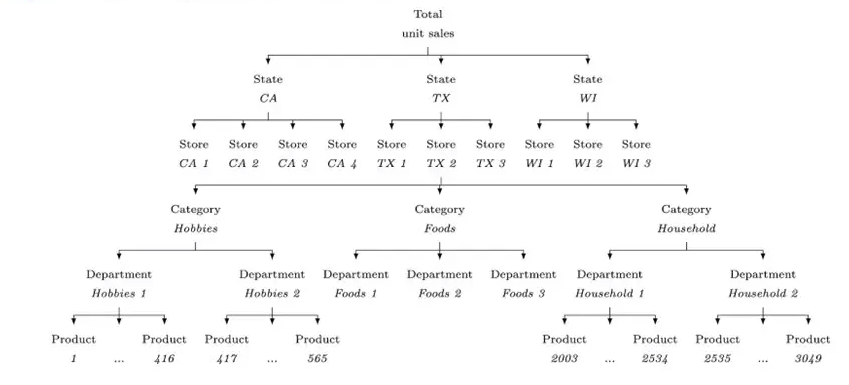

The 'sales_train' table contains the following columns:
- `id`: Unique id of a product in a certain store, combining all hierarchy information (store, state, department, and category) for the specific product. 
- `item_id`: Unique id of a specific product. 
- `dept_id`: Department of a specific product. 
- `cat_id`: Product category of a specific product. 
- `store_id`: Store in which the specific product was sold. 
- `state_id`: State in which the specific product was sold. 
- `d_1` bis `d_1941`: For each of the 1941 days, how many times the product has been sold on that day.

In [2]:
sales_train = pd.read_parquet('../Daten/Parquet/sales_train_evaluation.parquet')
sales_train_validation = pd.read_parquet('../Daten/Parquet/sales_train_validation.parquet')
sell_prices = pd.read_parquet('../Daten/Parquet/sell_prices.parquet')
calendar = pd.read_parquet('../Daten/Parquet/calendar.parquet')

In [3]:
sales_train.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [4]:
sales_train_validation.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


#### Exogenous/explanatory data
In addition to the sales data, additional explanatory data are available that provide additional context and help to interpret the patterns found.   

**'prices'**
- `store_id`: ID of the store.
- `item_id`: Product ID.
- `wm_yr_wk`: Identifier of the date (d_1 bis d_1969).
- `sell_price`: Selling prices of the products, provided on a week–store level (average across seven days). If not available, this means that the product was not sold during the week examined.

In [5]:
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


**'calendar'**
- `date`: Date (YYYY-MM-DD)
- `wm_yr_wk`: Date identifier
- `weekday`: Weekday
- `wday`: Saturday = 1, Sunday = 2 … Friday = 7
- `month`: Month
- `year`: Year
- `d`: Date identifier (d_1 to d_1969)
- `event_name_1`: Special events, days and holidays (e.g. Super Bowl, Valentine’s Day, and Orthodox Easter).
- `event_type_1`: Type of event (Cultural, Religious, Sporting, National).
- `event_name_2`: Name of the second event, if two events occur on the same day.
- `event_type_2`: Type of the second event, if two events occur on the same day.
- `snap_CA`: SNAP activities that serve as promotions. This is a binary variable (0 or 1) indicating whether the stores of *CA* allow SNAP purchases on the date examined, 1 indicates that SNAP purchases are allowed.
- `snap_TX`: SNAP activities for *TX* (Texas).
- `snap_WI`: SNAP activities for *WI* (Wisconsin).

SNAP is a social assistance program in the USA that provides money for food purchases for people in need using a debit card. The field is 1 if SNAP card purchases are allowed in CA (California) that day.


In [6]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,None,None,None,None,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,None,None,None,None,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,None,None,None,None,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,None,None,None,None,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,None,None,None,None,1,0,1


In [7]:
sales_train_T = sales_train.melt(id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], value_vars=[col for col in sales_train.columns if col.startswith('d_')], var_name='d' , value_name='sales')
sales_train_T.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [8]:
df_sales_calendar = sales_train_T.merge(calendar, on='d', how='left')
df_sales_calendar.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,None,None,None,None,0,0,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,None,None,None,None,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,None,None,None,None,0,0,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,None,None,None,None,0,0,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,None,None,None,None,0,0,0


In [9]:
df_complete = df_sales_calendar.merge(sell_prices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')
df_complete.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,None,None,None,None,0,0,0,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,None,None,None,None,0,0,0,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,None,None,None,None,0,0,0,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,None,None,None,None,0,0,0,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,None,None,None,None,0,0,0,NaN


In [10]:
df_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59181090 entries, 0 to 59181089
Data columns (total 22 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            object 
 1   item_id       object 
 2   dept_id       object 
 3   cat_id        object 
 4   store_id      object 
 5   state_id      object 
 6   d             object 
 7   sales         int64  
 8   date          object 
 9   wm_yr_wk      int64  
 10  weekday       object 
 11  wday          int64  
 12  month         int64  
 13  year          int64  
 14  event_name_1  object 
 15  event_type_1  object 
 16  event_name_2  object 
 17  event_type_2  object 
 18  snap_CA       int64  
 19  snap_TX       int64  
 20  snap_WI       int64  
 21  sell_price    float64
dtypes: float64(1), int64(8), object(13)
memory usage: 9.7+ GB


In [11]:
df_complete.describe()

,sales,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI,sell_price
count,5.918109e+07,5.918109e+07,5.918109e+07,5.918109e+07,5.918109e+07,5.918109e+07,5.918109e+07,5.918109e+07,4.688168e+07
mean,1.130888e+00,1.134317e+04,3.997424e+00,6.334879e+00,2.013249e+03,3.297269e-01,3.297269e-01,3.297269e-01,4.409438e+00
std,3.870038e+00,1.528596e+02,2.000642e+00,3.439200e+00,1.556974e+00,4.701139e-01,4.701139e-01,4.701139e-01,3.406106e+00
min,0.000000e+00,1.110100e+04,1.000000e+00,1.000000e+00,2.011000e+03,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e-02
25%,0.000000e+00,1.121800e+04,2.000000e+00,3.000000e+00,2.012000e+03,0.000000e+00,0.000000e+00,0.000000e+00,2.180000e+00
50%,0.000000e+00,1.133500e+04,4.000000e+00,6.000000e+00,2.013000e+03,0.000000e+00,0.000000e+00,0.000000e+00,3.470000e+00
75%,1.000000e+00,1.145100e+04,6.000000e+00,9.000000e+00,2.015000e+03,1.000000e+00,1.000000e+00,1.000000e+00,5.840000e+00
max,7.630000e+02,1.161700e+04,7.000000e+00,1.200000e+01,2.016000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.073200e+02


In [12]:
df_complete = df_complete[(df_complete['state_id'] == 'CA') &  (df_complete['cat_id'] == 'FOODS')]

### 1.2 Seasonality

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
from plotly.subplots import make_subplots
import plotly.graph_objects as go

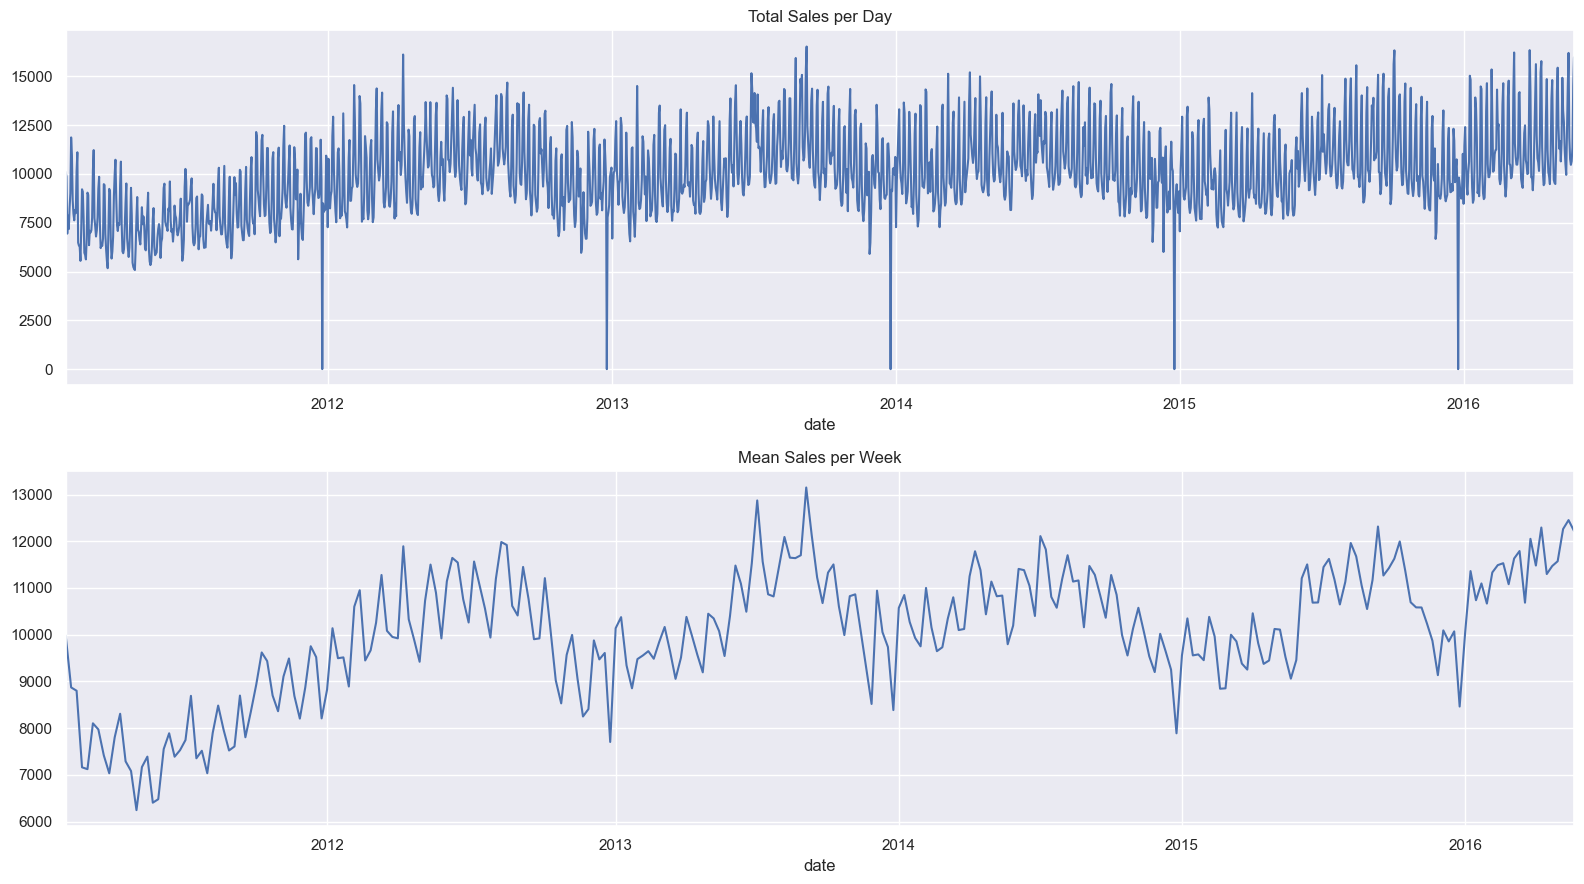

In [14]:
grouped_sales_total = df_complete[['date', 'sales']].groupby('date').sum()
grouped_sales_total.index = pd.to_datetime(grouped_sales_total.index)

weekly_sales = grouped_sales_total['sales'].resample('W').mean()


fig, ax = plt.subplots(2, figsize=(16, 9))

grouped_sales_total['sales'].plot(title='Total Sales per Day', ax=ax[0])
weekly_sales.plot(title='Mean Sales per Week', ax=ax[1])

plt.tight_layout() 
plt.show()


In [15]:
def plot_components(result):

  df = pd.concat([result.observed, result.trend, result.seasonal, result.resid], axis=1)
  df = df.rename(columns={0:'Original Data', 'season':'seasonal','observed':'Original Data'})
  components = df.columns
  rows = len(components)
  fig = make_subplots(rows=rows, cols=1, shared_xaxes=True, subplot_titles = [i for i in components])

  # Plot original data
  for i, col in enumerate(components):
    fig.add_trace(go.Scatter(x=df.index, y=df[col], mode='lines', name=col), row=i+1, col=1)


  # Update layout
  fig.update_layout(
      title='Time Series Decomposition',
      xaxis_title='Time',
      height=1200,
      width=1200
  )

  fig.show()

In [16]:
period = 365 #setting the period for decomposition
# Apply seasonal_decompose
result_sd = seasonal_decompose(grouped_sales_total['sales'], model='additive', period=period, extrapolate_trend=1)

# Plot the results
plot_components(result_sd)

### 1.3 Autocorrelation

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

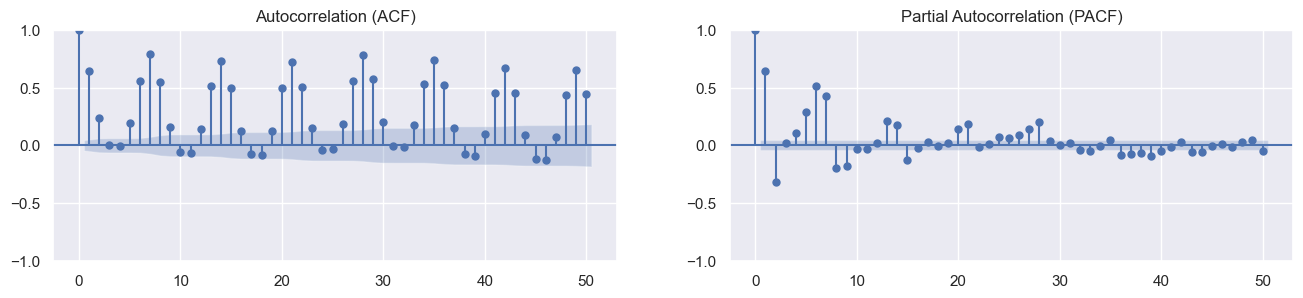

In [18]:
# ACF and PACF plots of the total sales
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(grouped_sales_total['sales'].tolist(), lags=50, ax=axes[0], title='Autocorrelation (ACF)')
plot_pacf(grouped_sales_total['sales'].tolist(), lags=50, ax=axes[1], title='Partial Autocorrelation (PACF)')
plt.show()

We can see that the autocorrelation is present. Especially values autocorrelate with values from the same day in previous weeks.

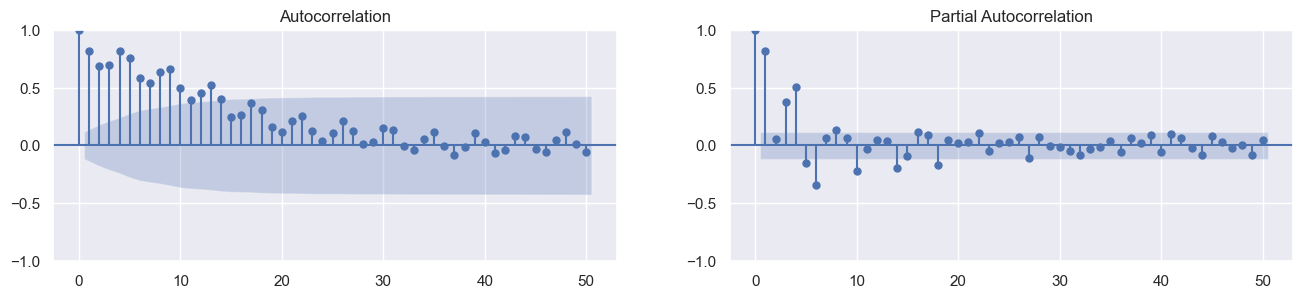

In [19]:
# ACF and PACF plots of the weekly sales
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(weekly_sales.tolist(), lags=50, ax=axes[0])
plot_pacf(weekly_sales.tolist(), lags=50, ax=axes[1])
plt.show()


Weekly sales has weaker autocorrelation. This implies that the seasonality of weekdays has a strong impact on the data.

### 1.4 Stationarity

In [20]:
from statsmodels.tsa.stattools import adfuller

In [21]:
result = adfuller(weekly_sales)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is not stationary.")

ADF Statistic: -2.6531410542698
p-value: 0.08250377761794797
The series is not stationary.


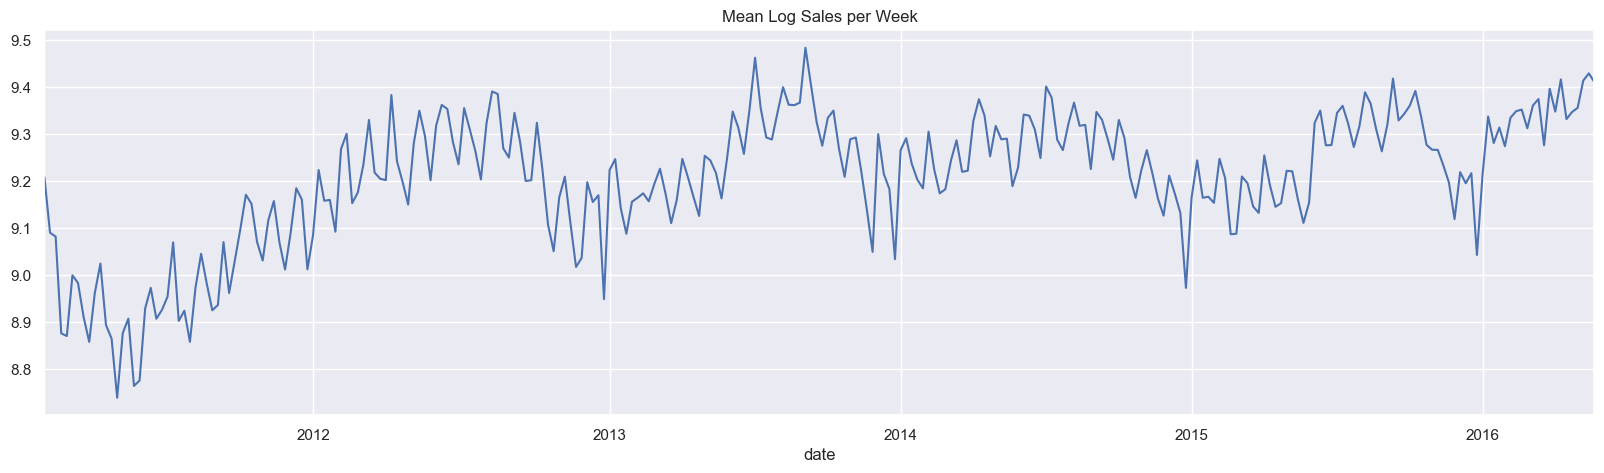

ADF Statistic: -2.989848610051132
p-value: 0.0358533491955857
The series is stationary.


In [22]:
# Log Transformation
weekly_sales_log = np.log(weekly_sales)

weekly_sales_log.plot(figsize=(20, 5), title='Mean Log Sales per Week')
plt.show()

result = adfuller(weekly_sales_log)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is not stationary.")

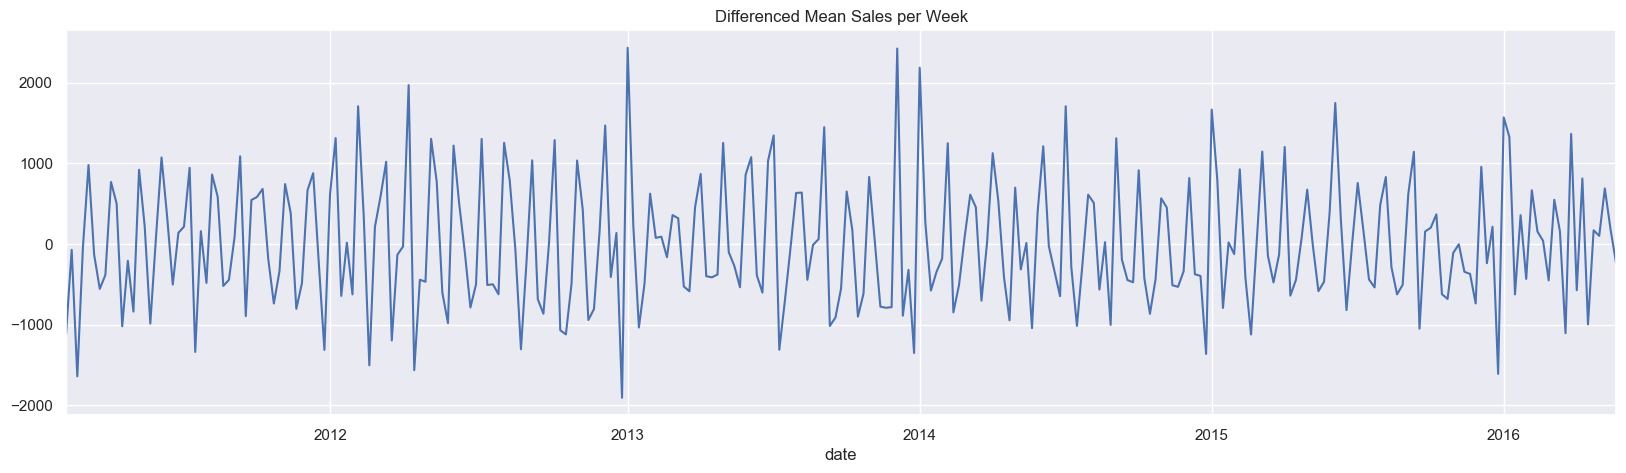

ADF Statistic: -3.985689864374339
p-value: 0.0014873250876994218
The series is stationary.


In [23]:
# Differencing
# Removes trends by subtracting the previous value from the current value
# First-order differencing removes linear trends

weekly_sales_diff = weekly_sales.diff().dropna()

weekly_sales_diff.plot(figsize=(20, 5), title='Differenced Mean Sales per Week')
plt.show()

result = adfuller(weekly_sales_diff)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is not stationary.")

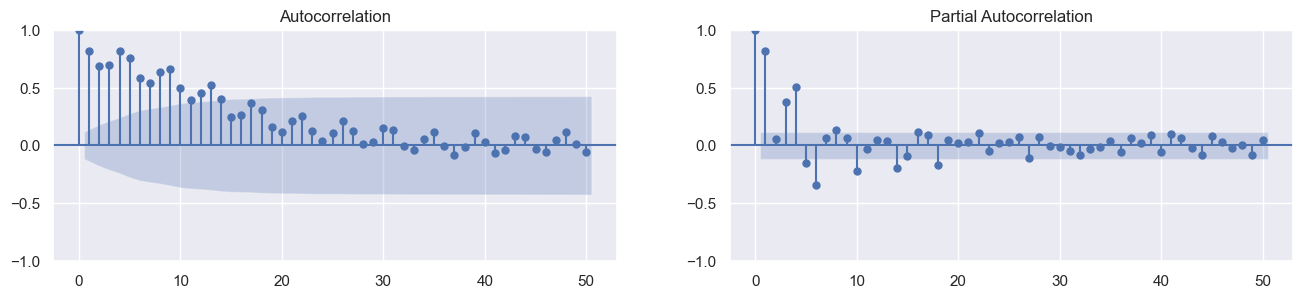

In [24]:
# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(weekly_sales, lags=50, ax=axes[0])
plot_pacf(weekly_sales, lags=50, ax=axes[1])
plt.show()

## 2. Forecasting Models

### 2.1 ARIMA


In [25]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import root_mean_squared_error

In [26]:
arima_model = ARIMA(weekly_sales[:-28], order=(3, 2, 3))
arima_model_fit = arima_model.fit()

/Users/tillcarloschelhorn/miniconda3/envs/bis_exercise/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



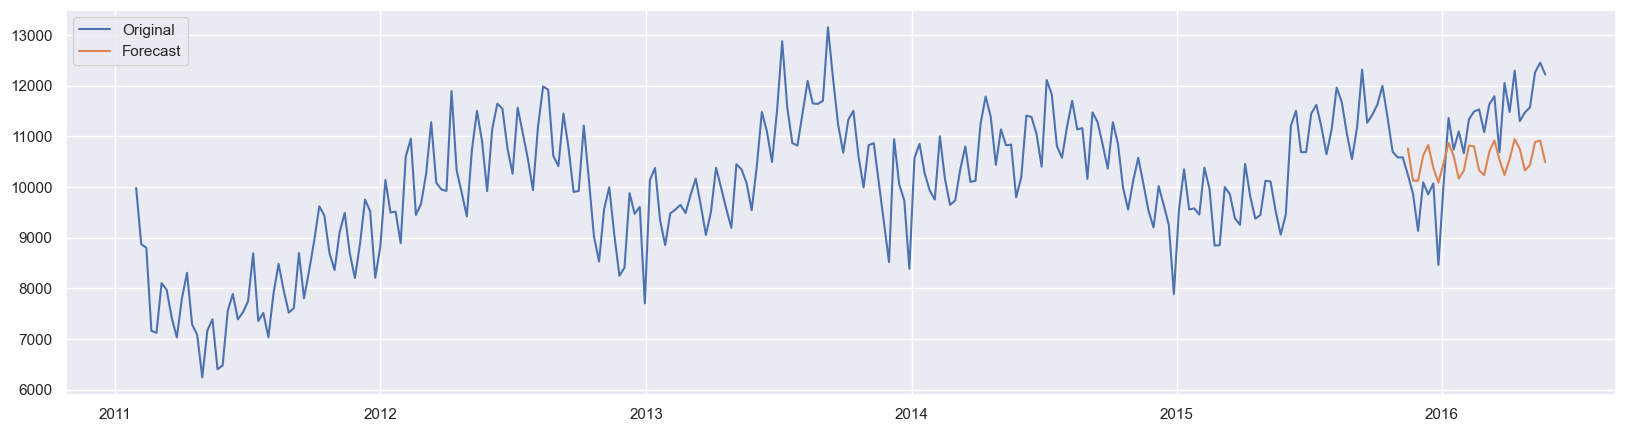

In [27]:
# Get d_1914 - d_1941
forecast = arima_model_fit.forecast(steps=28)
forecast = pd.Series(forecast, index=weekly_sales.index[-28:])

plt.figure(figsize=(20, 5))
plt.plot(weekly_sales, label='Original')
plt.plot(forecast, label='Forecast')
plt.legend()

In [28]:
auto_arima_model = auto_arima(weekly_sales[:-28], seasonal=False, trace=True)
print(auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3874.347, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4039.003, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4035.924, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3993.188, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4037.007, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3970.269, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3933.582, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3813.523, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3874.955, Time=0.03 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3815.314, Time=0.14 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3815.087, Time=0.12 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3828.047, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3870.397, Time=0.08 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=3815.681, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0]          

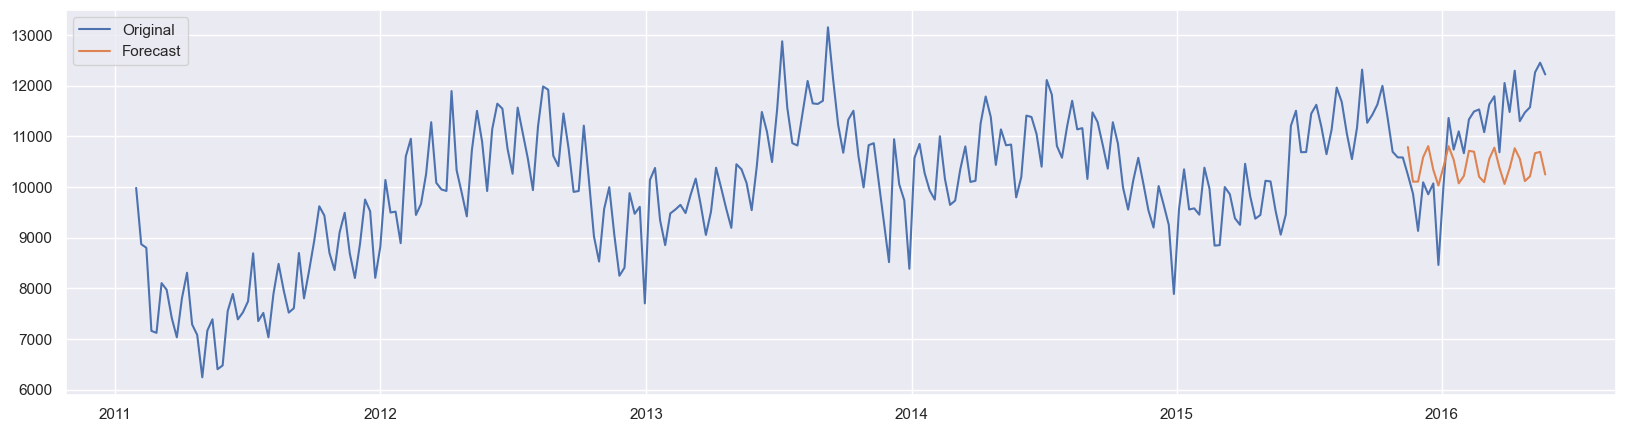

In [29]:
forecast = auto_arima_model.predict(n_periods=28)
forecast = pd.Series(forecast, index=weekly_sales.index[-28:])

plt.figure(figsize=(20, 5))
plt.plot(weekly_sales, label='Original')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.show()

### 2.2 Prophet


In [30]:
from prophet import Prophet

/Users/tillcarloschelhorn/miniconda3/envs/bis_exercise/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [31]:
data = pd.DataFrame({'ds': grouped_sales_total['sales'].index, 'y': grouped_sales_total['sales'].values})

In [32]:
model = Prophet()
model.fit(data.iloc[:-28])

10:30:34 - cmdstanpy - INFO - Chain [1] start processing
10:30:34 - cmdstanpy - INFO - Chain [1] done processing


In [33]:
future = model.make_future_dataframe(periods=28)
future.tail()

,ds
1936,2016-05-18
1937,2016-05-19
1938,2016-05-20
1939,2016-05-21
1940,2016-05-22


In [34]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1936,2016-05-18,10094.787154,8707.011804,11441.148806
1937,2016-05-19,10153.638336,8789.093805,11596.944726
1938,2016-05-20,11293.973510,9875.413549,12796.352109
1939,2016-05-21,13485.895074,12255.043686,14846.462731
1940,2016-05-22,13827.850848,12359.462317,15156.040084


[]

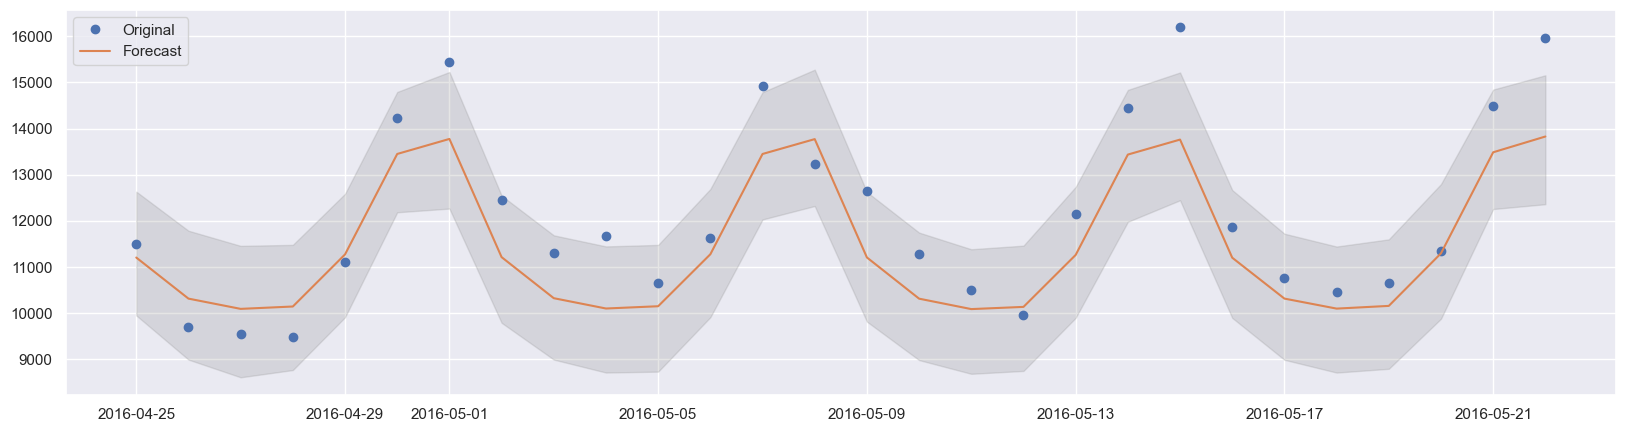

In [35]:
plt.figure(figsize=(20, 5))
plt.plot(data.iloc[-28:]['ds'], data.iloc[-28:]['y'], 'o', label='Original', )
plt.plot(forecast.iloc[-28:]['ds'], forecast.iloc[-28:]['yhat'], label='Forecast')
plt.fill_between(forecast.iloc[-28:]['ds'], forecast.iloc[-28:]['yhat_lower'], forecast.iloc[-28:]['yhat_upper'], color='gray', alpha=0.2)
plt.legend()
plt.plot()

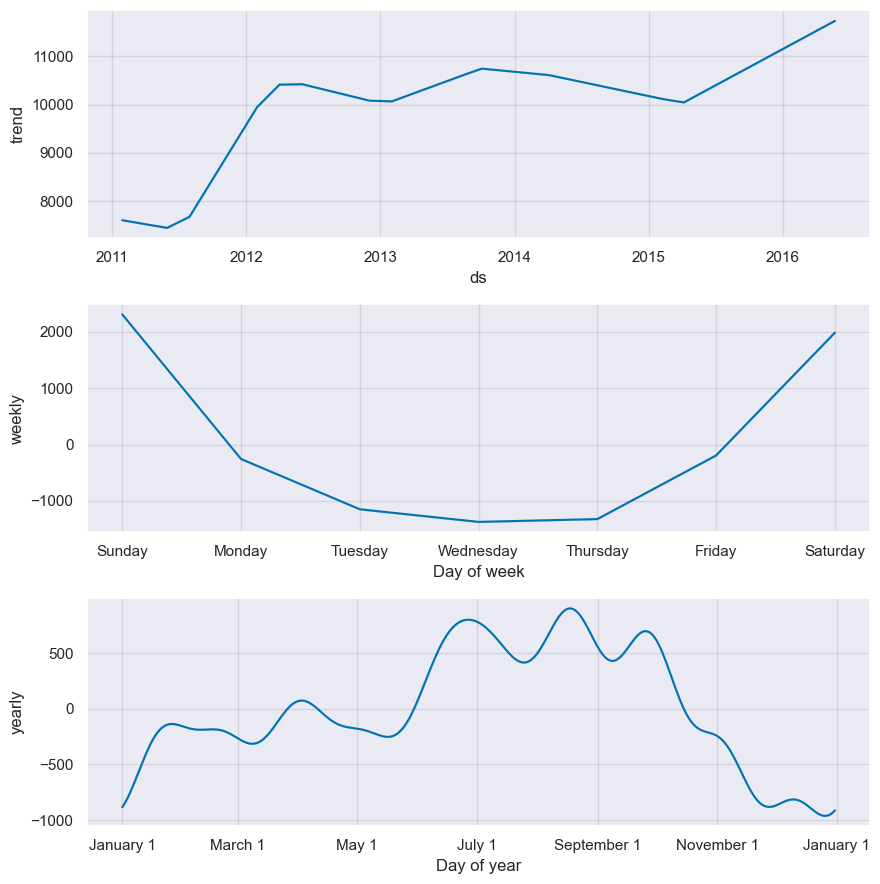

In [36]:
fig = model.plot_components(forecast)

In [37]:
grouped_state_cat = df_complete[['store_id', 'cat_id', 'date', 'sales']].groupby(['store_id', 'cat_id', 'date']).sum()
grouped_state_cat = grouped_state_cat.reset_index()

10:30:37 - cmdstanpy - INFO - Chain [1] start processing
10:30:37 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/vb/yntgn1yj343804r0tflchw440000gn/T/ipykernel_43808/2454026262.py:30: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

10:30:37 - cmdstanpy - INFO - Chain [1] start processing
10:30:37 - cmdstanpy - INFO - Chain [1] done processing
10:30:37 - cmdstanpy - INFO - Chain [1] start processing
10:30:37 - cmdstanpy - INFO - Chain [1] done processing
10:30:38 - cmdstanpy - INFO - Chain [1] start processing
10:30:38 - cmdstanpy - INFO - Chain [1] done processing


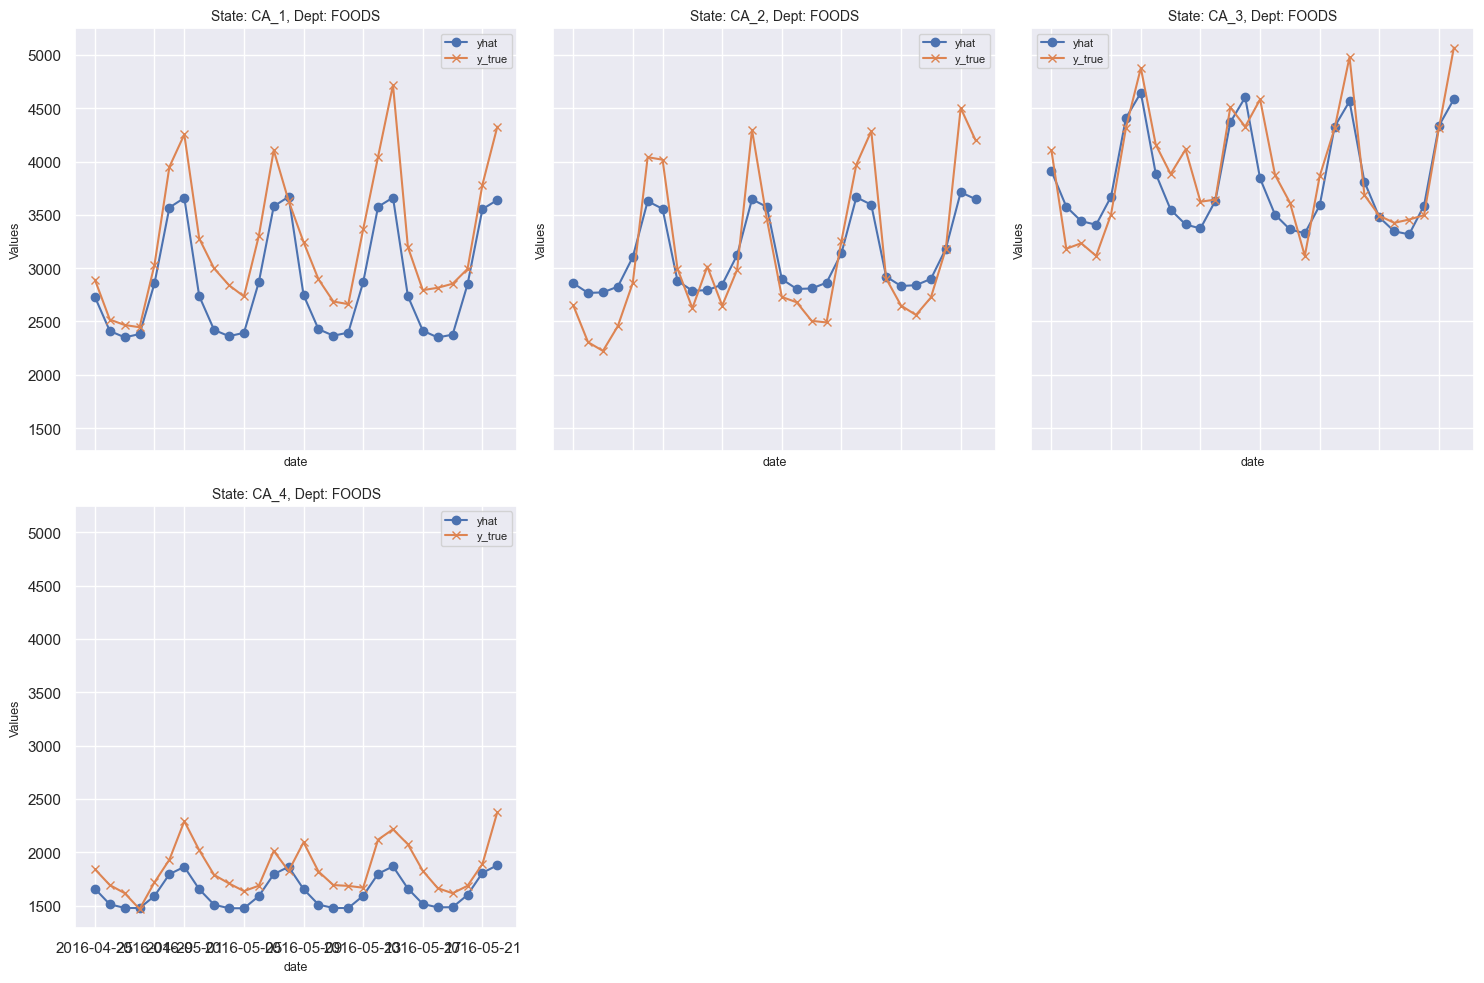

In [38]:
unique_combinations = grouped_state_cat[['store_id', 'cat_id']].drop_duplicates()

# Calculate the grid size for subplots
n_combinations = len(unique_combinations)
n_cols = 3  # Number of columns in the grid
n_rows = (n_combinations + n_cols - 1) // n_cols  # Calculate rows needed

# Create subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), sharex=True, sharey=True)
axs = axs.flatten()


results = pd.DataFrame(columns=['store_id', 'cat_id', 'ds', 'y_true', 'yhat', 'yhat_lower', 'yhat_upper'])

for i, (store, cat) in enumerate(unique_combinations.values):
    filtered_data = grouped_state_cat[(grouped_state_cat['store_id'] == store) & (grouped_state_cat['cat_id'] == cat)]

    data = pd.DataFrame({'ds': filtered_data['date'], 'y': filtered_data['sales']})

    prophet_model = Prophet()
    prophet_model.fit(data.iloc[:-28])

    future = prophet_model.make_future_dataframe(periods=28)
    forecast = prophet_model.predict(future)

    forecast['store_id'] = store
    forecast['cat_id'] = cat
    forecast['y_true'] = filtered_data['sales'].values

    results = pd.concat([results, forecast.iloc[-28:][['store_id', 'cat_id', 'ds', 'y_true', 'yhat', 'yhat_lower', 'yhat_upper']]], axis=0)

    ax = axs[i]
    ax.plot(forecast.iloc[-28:]['ds'], forecast.iloc[-28:]['yhat'], label='yhat', marker='o')
    ax.plot(forecast.iloc[-28:]['ds'], forecast.iloc[-28:]['y_true'], label='y_true', marker='x')
    ax.set_title(f"State: {store}, Dept: {cat}", fontsize=10)
    ax.set_xlabel("date", fontsize=9)
    ax.set_ylabel("Values", fontsize=9)
    ax.legend(fontsize=8)
    ax.grid(True)

# Remove any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

### 2.3 XGBoost

In [39]:
import xgboost as xgb

#### 2.3.1 Feature Engineering

In [40]:
# Tranform categorical features
# Alternatively use one-hot encoding or label encoding
for col in ['dept_id', 'cat_id', 'store_id', 'state_id', 'item_id']:
    df_complete[col] = df_complete[col].astype('category')

In [41]:
# Lag features
# Capture the effect of previous sales on current sales
lags = [1, 2, 7, 14, 21, 28, 35, 365]

for lag in lags:
    df_complete[f'lag_{lag}'] = df_complete.groupby(['id'])['sales'].shift(lag)

    # Fill NaN values with 0
    df_complete.fillna({f'lag_{lag}' : 0}, inplace=True)

In [42]:
# Rolling mean features
# Capture the average sales over a specific time window
rolling_mean_windows = [7, 14, 28]

for window in rolling_mean_windows:
    df_complete[f'rolling_mean_{window}'] = df_complete.groupby(['id'])['sales'].transform(lambda x: x.rolling(window=window).mean())

    # Fill NaN values with 0
    df_complete.fillna({f'rolling_mean_{window}' : 0}, inplace=True)

Some features are cyclic (e.g. month, weekday). This leads to large jumps in values (i.e. Dec-Jan is difference of 11). Some models do not handle this behavior well. Therefore we need to encode them. One possible way of doing this is one-hot encodeing. Another apporach is the use of basic mathematical functions that represent the values in a vector space. Here we use sine/cosine encoding.

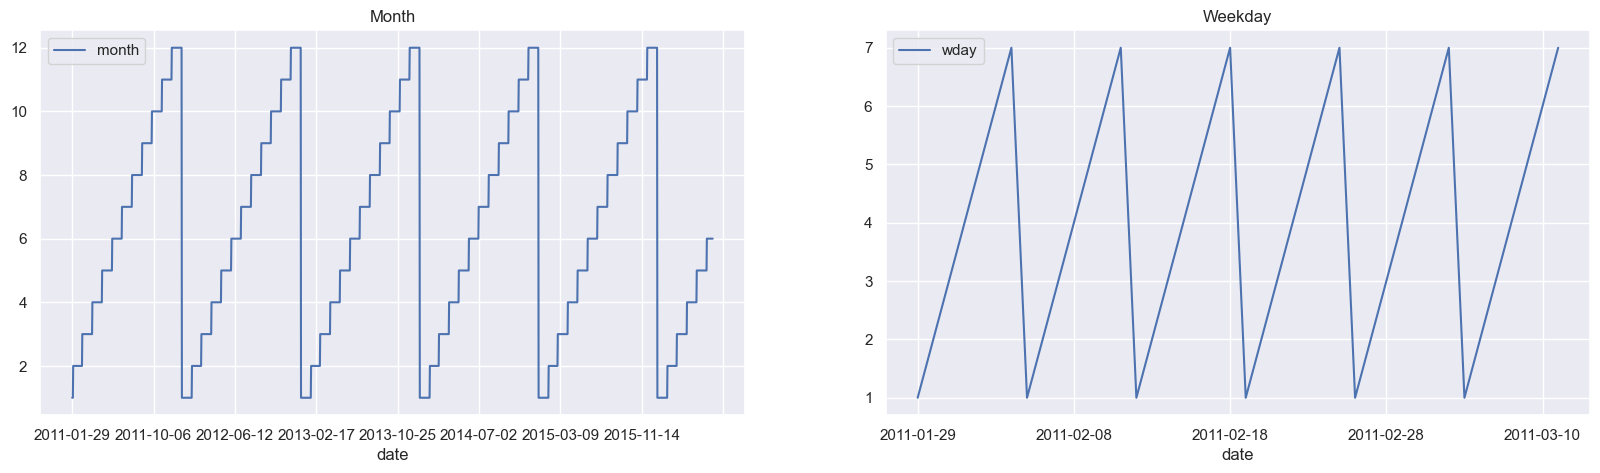

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

calendar.plot(x='date', y='month', ax=axes[0], title='Month')
calendar.iloc[:42].plot(x='date', y='wday', ax=axes[1], title='Weekday')

plt.show()

In [44]:
# Sin/Cosine Encoding
def encode(values, max_val):
    return np.sin(2 * np.pi * values/max_val), np.cos(2 * np.pi * values/max_val)

In [45]:
df_complete['month_sin'], df_complete['month_cos'] = encode(df_complete['month'], 12)
df_complete['wday_sin'], df_complete['wday_cos'] = encode(df_complete['wday'], 7)

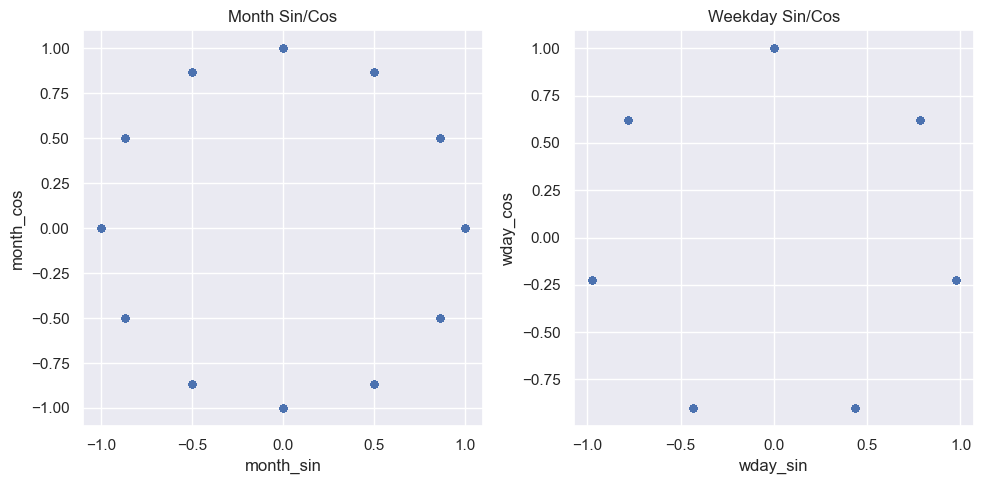

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Create 1 row and 2 columns of subplots
df_complete[df_complete['id'] == 'FOODS_1_001_CA_1_evaluation'].plot(x='month_sin', y='month_cos', kind='scatter', ax=axes[0], title='Month Sin/Cos')
df_complete[df_complete['id'] == 'FOODS_1_001_CA_1_evaluation'].plot(x='wday_sin', y='wday_cos', kind='scatter', ax=axes[1], title='Weekday Sin/Cos')

plt.tight_layout()
plt.show()

Now the distance between each value is equal.

In [47]:
features = [
    'sell_price',
    'snap_CA', 'snap_TX', 'snap_WI', 
    'month_sin', 'month_cos', 'wday_sin', 'wday_cos', 'year', 'd_int',
    'dept_id', 'cat_id', 'store_id', 'state_id', 'item_id',
    'lag_1', 'lag_2', 'lag_7', 'lag_14', 'lag_21', 'lag_28', 'lag_35', 'lag_365',
    'rolling_mean_7', 'rolling_mean_14', 'rolling_mean_28'
    ]

#### 2.3.2 Model Training

In [48]:
last_train_day = 1913

df_complete['d_int'] = df_complete['d'].str.replace('d_', '').astype(int)

train, test = df_complete[df_complete['d_int'] <= last_train_day], df_complete[df_complete['d_int'] > last_train_day]

X_train = train[features]
y_train = train['sales']

X_test = test[features]
y_test = test['sales']

In [49]:
xgb_model = xgb.XGBRegressor(
    early_stopping_rounds=10,
    enable_categorical=True,
)

In [50]:
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=True
)

[0]	validation_0-rmse:4.20632	validation_1-rmse:3.50117
[1]	validation_0-rmse:3.46387	validation_1-rmse:2.87091
[2]	validation_0-rmse:3.02625	validation_1-rmse:2.49681
[3]	validation_0-rmse:2.77030	validation_1-rmse:2.28685
[4]	validation_0-rmse:2.61984	validation_1-rmse:2.17469
[5]	validation_0-rmse:2.53832	validation_1-rmse:2.11469
[6]	validation_0-rmse:2.48072	validation_1-rmse:2.08078
[7]	validation_0-rmse:2.44952	validation_1-rmse:2.06324
[8]	validation_0-rmse:2.42532	validation_1-rmse:2.05337
[9]	validation_0-rmse:2.40837	validation_1-rmse:2.04613
[10]	validation_0-rmse:2.39627	validation_1-rmse:2.03993
[11]	validation_0-rmse:2.38785	validation_1-rmse:2.03659
[12]	validation_0-rmse:2.38025	validation_1-rmse:2.03440
[13]	validation_0-rmse:2.37211	validation_1-rmse:2.03148
[14]	validation_0-rmse:2.36691	validation_1-rmse:2.03038
[15]	validation_0-rmse:2.35951	validation_1-rmse:2.03022
[16]	validation_0-rmse:2.35619	validation_1-rmse:2.03014
[17]	validation_0-rmse:2.35170	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [51]:
y_pred = xgb_model.predict(X_test)

In [52]:
X_test['y_pred'] = y_pred.round()
X_test['y_true'] = y_test

/var/folders/vb/yntgn1yj343804r0tflchw440000gn/T/ipykernel_43808/1671534205.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/vb/yntgn1yj343804r0tflchw440000gn/T/ipykernel_43808/1671534205.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### 2.3.3 Model Evaluation

In [53]:
grouped_X_test = X_test[['y_pred', 'y_true', 'store_id', 'cat_id', 'd_int']].groupby(['store_id', 'cat_id', 'd_int']).sum()
grouped_X_test = grouped_X_test.reset_index()


/var/folders/vb/yntgn1yj343804r0tflchw440000gn/T/ipykernel_43808/1739179302.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



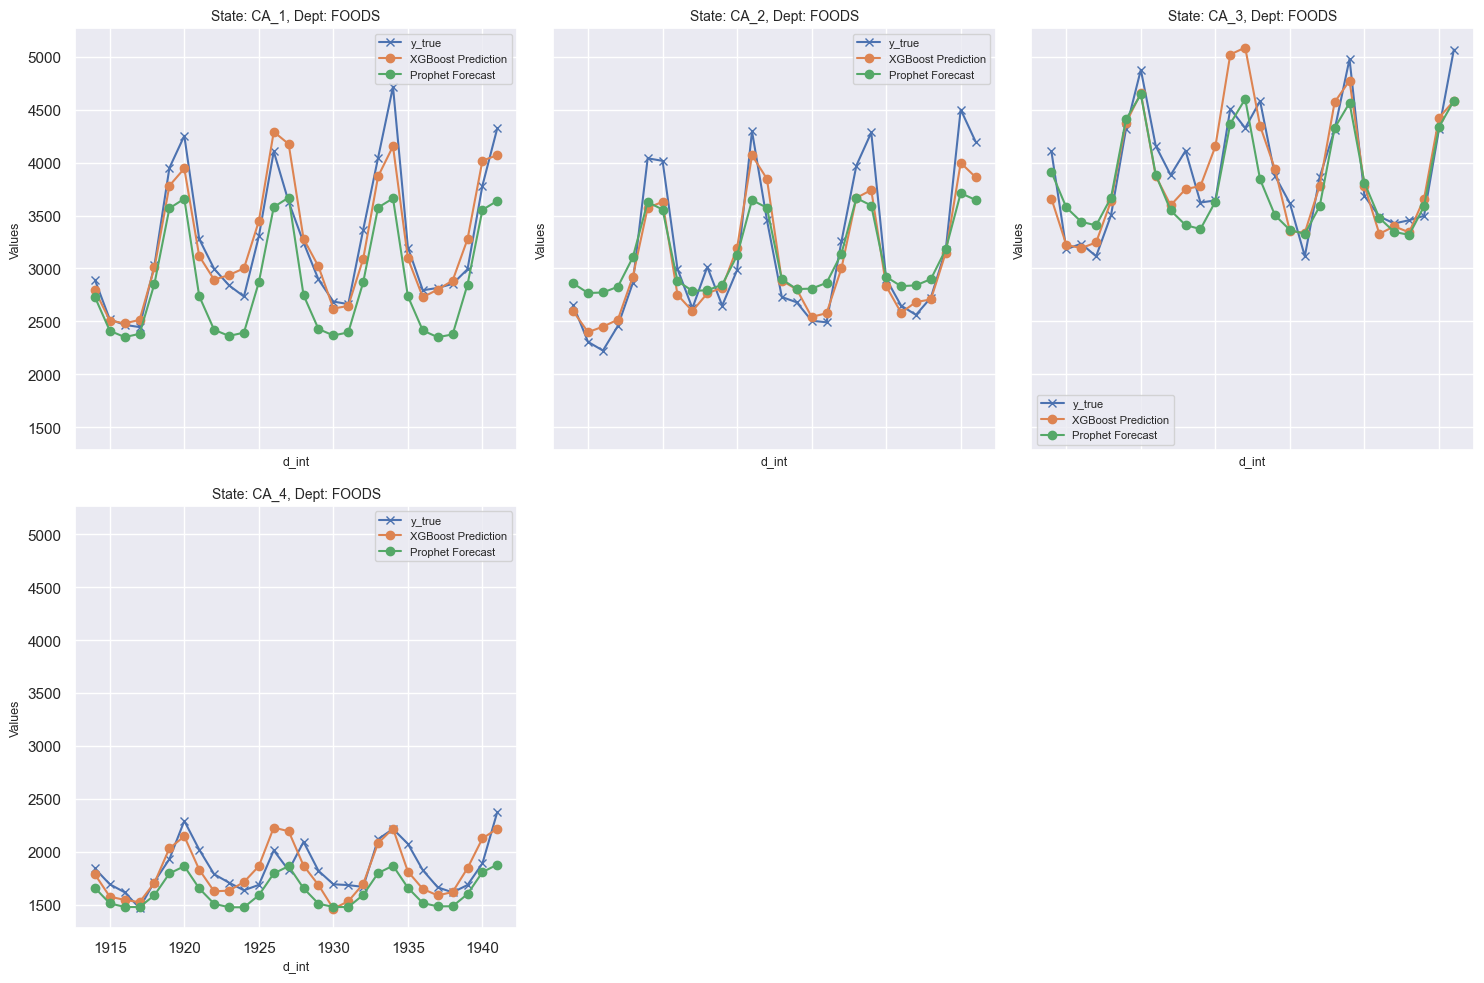

In [54]:
# Get unique combinations of state_id and dept_id for subplot creation
unique_combinations = grouped_X_test[['store_id', 'cat_id']].drop_duplicates()

# Calculate the grid size for subplots
n_combinations = len(unique_combinations)
n_cols = 3  # Number of columns in the grid
n_rows = (n_combinations + n_cols - 1) // n_cols  # Calculate rows needed

# Create subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), sharex=True, sharey=True)
axs = axs.flatten()

# Plot each store_id and dept_id combination
for i, (store, cat) in enumerate(unique_combinations.values):
    filtered_data = grouped_X_test[(grouped_X_test['store_id'] == store) &
                                   (grouped_X_test['cat_id'] == cat)]
    
    prophet_prediction = results[(results['store_id'] == store) & (results['cat_id'] == cat)]
    
    ax = axs[i]
    ax.plot(filtered_data['d_int'], filtered_data['y_true'], label='y_true', marker='x')
    ax.plot(filtered_data['d_int'], filtered_data['y_pred'], label='XGBoost Prediction', marker='o')
    ax.plot(filtered_data['d_int'], prophet_prediction['yhat'], label='Prophet Forecast', marker='o')
    ax.set_title(f"State: {store}, Dept: {cat}", fontsize=10)
    ax.set_xlabel("d_int", fontsize=9)
    ax.set_ylabel("Values", fontsize=9)
    ax.legend(fontsize=8)
    ax.grid(True)

# Remove any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

## Tasks

### Task 1: Compare the RMSE of the Prophet models with the XGBoost model overall and on store level

In [55]:
print('RMSE XGBoost ', round(root_mean_squared_error(grouped_X_test['y_true'], grouped_X_test['y_pred']), 2))
print('RMSE Prophet  ', round(root_mean_squared_error(results['y_true'], results['yhat']), 2))

RMSE XGBoost  232.14
RMSE Prophet   349.26


In [56]:
for i, (store, cat) in enumerate(unique_combinations.values):
    xgb_rmse = root_mean_squared_error(
        grouped_X_test[(grouped_X_test['store_id'] == store) & (grouped_X_test['cat_id'] == cat)]['y_true'], 
        grouped_X_test[(grouped_X_test['store_id'] == store) & (grouped_X_test['cat_id'] == cat)]['y_pred']
    )
    prophet_rmse = root_mean_squared_error(
        results[(results['store_id'] == store) & (results['cat_id'] == cat)]['y_true'], 
        results[(results['store_id'] == store) & (results['cat_id'] == cat)]['yhat']
    )

    print('-----------------------------------')
    print(f'State: {store}, Dept: {cat}')
    print(f'RMSE XGBoost: {round(xgb_rmse, 2)}')
    print(f'RMSE Prophet: {round(prophet_rmse, 2)}')


-----------------------------------
State: CA_1, Dept: FOODS
RMSE XGBoost: 213.03
RMSE Prophet: 446.74
-----------------------------------
State: CA_2, Dept: FOODS
RMSE XGBoost: 248.62
RMSE Prophet: 360.96
-----------------------------------
State: CA_3, Dept: FOODS
RMSE XGBoost: 288.48
RMSE Prophet: 303.71
-----------------------------------
State: CA_4, Dept: FOODS
RMSE XGBoost: 158.57
RMSE Prophet: 256.55


### Task 2: Identify the 5 features most used for splits and the 5 most influencial features of the XGBoost model

In [57]:
from xgboost import plot_importance

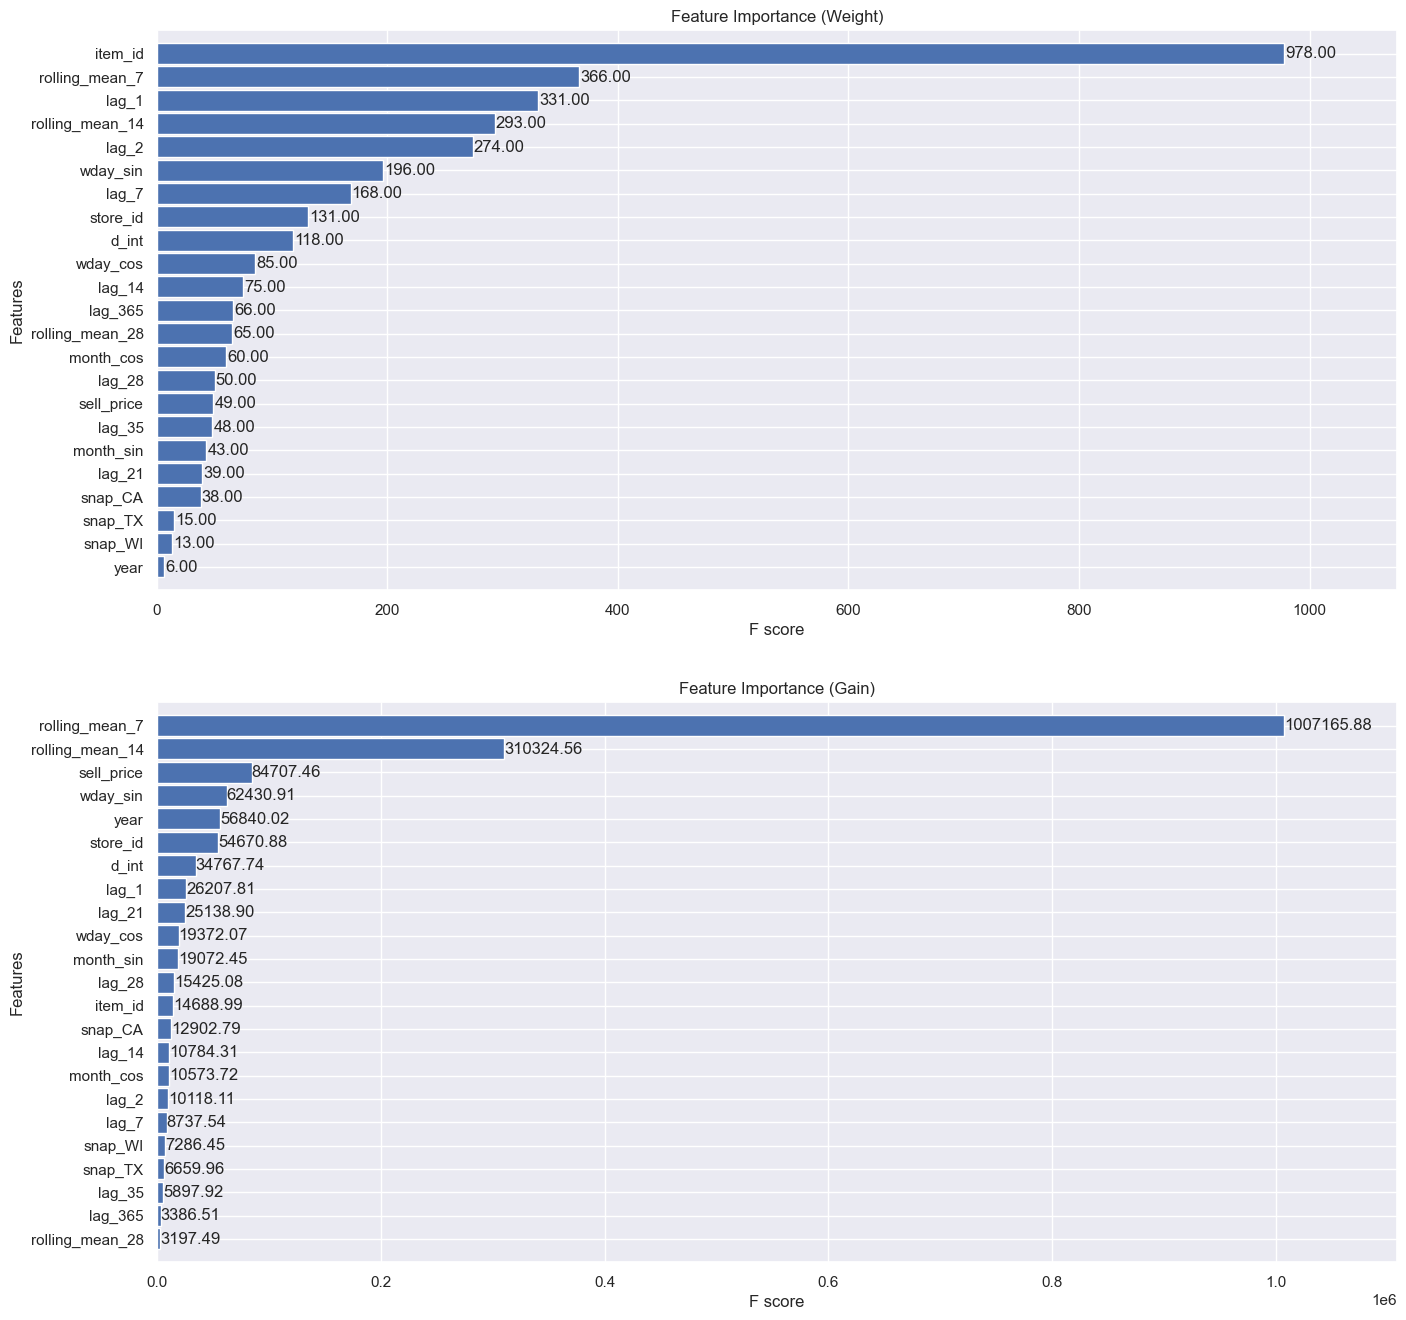

In [58]:
fig, ax = plt.subplots(2, figsize=(16, 16))
plot_importance(xgb_model, height=0.9, importance_type='weight', ax=ax[0], title='Feature Importance (Weight)', values_format="{v:.2f}")
plot_importance(xgb_model, height=0.9, importance_type='gain', ax=ax[1], title='Feature Importance (Gain)', values_format="{v:.2f}")
plt.show()

The 5 features that were used for splitting most often:
- item_id
- rolling_mean_7
- lag_1
- n_14
- lag_2


The most influencial feature on model performance:
- 

## Further Extensions

- Add event data as feature
- GridSearch to find the optimal model parameters
- ARIMA/Prophet prediction as feature
- Iterative prediction (include prediciton of t-1 at t)
